# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE_tune/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,
                                                     patience=1, verbose=True, eps=1e-6)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, scheduler, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-11 19:02:49,211 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-11 19:02:49,212 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-11 19:02:50,048 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:20<00:00, 88.44it/s]


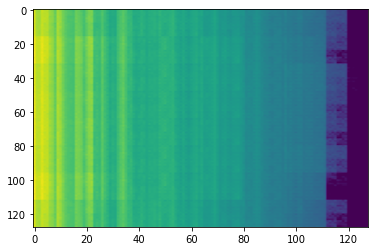

2020-11-11 19:04:08,960 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:932.481891, valid_AUC:0.518963, valid_pAUC:0.502973
100%|██████████| 1803/1803 [00:20<00:00, 86.47it/s]
2020-11-11 19:05:25,311 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:859.070146, valid_AUC:0.524446, valid_pAUC:0.502907
100%|██████████| 1803/1803 [00:19<00:00, 93.16it/s]
2020-11-11 19:06:40,090 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:793.619492, valid_AUC:0.528238, valid_pAUC:0.503442
100%|██████████| 1803/1803 [00:19<00:00, 92.79it/s]
2020-11-11 19:07:54,402 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:733.774582, valid_AUC:0.519565, valid_pAUC:0.503404
100%|██████████| 1803/1803 [00:19<00:00, 93.10it/s]
2020-11-11 19:09:08,610 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:678.624207, valid_AUC:0.519547, valid_pAUC:0.506752
100%|██████████| 1803/1803 [00:19<00:00, 92.49it/s]
2020-11-11 19:10:23,008 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:627.419184, valid_

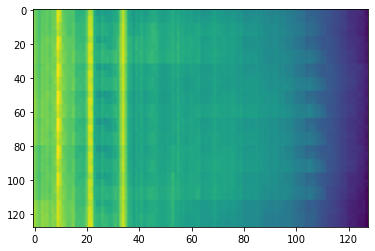

2020-11-11 19:15:16,983 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:456.752157, valid_AUC:0.530770, valid_pAUC:0.511751
100%|██████████| 1803/1803 [00:18<00:00, 95.56it/s]
2020-11-11 19:16:30,350 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:420.799757, valid_AUC:0.533061, valid_pAUC:0.508394
100%|██████████| 1803/1803 [00:18<00:00, 95.54it/s]
2020-11-11 19:17:43,698 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:386.907309, valid_AUC:0.489592, valid_pAUC:0.519751
100%|██████████| 1803/1803 [00:20<00:00, 86.67it/s]
2020-11-11 19:19:00,234 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:356.425306, valid_AUC:0.536605, valid_pAUC:0.508000
100%|██████████| 1803/1803 [00:19<00:00, 90.22it/s]
2020-11-11 19:20:16,266 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:325.999016, valid_AUC:0.487478, valid_pAUC:0.509003
100%|██████████| 1803/1803 [00:21<00:00, 83.58it/s]
2020-11-11 19:21:33,589 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:297.959426, 

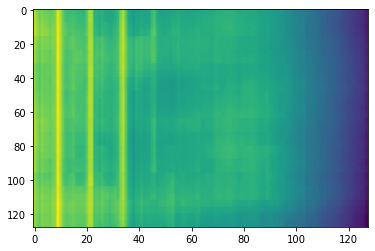

2020-11-11 19:27:52,971 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:184.284871, valid_AUC:0.502855, valid_pAUC:0.507934
100%|██████████| 1803/1803 [00:20<00:00, 89.90it/s]
2020-11-11 19:29:09,020 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:166.167390, valid_AUC:0.489849, valid_pAUC:0.506696
100%|██████████| 1803/1803 [00:21<00:00, 85.65it/s]
2020-11-11 19:30:26,347 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:149.479426, valid_AUC:0.480664, valid_pAUC:0.509960
100%|██████████| 1803/1803 [00:20<00:00, 89.82it/s]
2020-11-11 19:31:42,955 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:134.086982, valid_AUC:0.558758, valid_pAUC:0.513833
100%|██████████| 1803/1803 [00:21<00:00, 84.37it/s]
2020-11-11 19:33:00,245 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:119.964941, valid_AUC:0.497817, valid_pAUC:0.514190
100%|██████████| 1803/1803 [00:20<00:00, 90.12it/s]
2020-11-11 19:34:15,841 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:106.983946, 

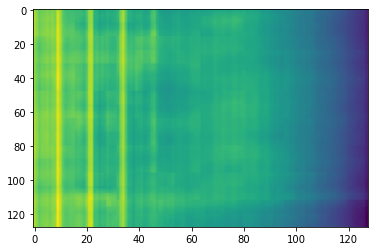

2020-11-11 19:40:37,234 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:58.041366, valid_AUC:0.492192, valid_pAUC:0.511254
100%|██████████| 1803/1803 [00:19<00:00, 93.46it/s]
2020-11-11 19:41:52,281 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:51.002240, valid_AUC:0.551403, valid_pAUC:0.517219
100%|██████████| 1803/1803 [00:20<00:00, 88.90it/s]
2020-11-11 19:43:07,618 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:44.766509, valid_AUC:0.594301, valid_pAUC:0.515062
100%|██████████| 1803/1803 [00:20<00:00, 89.11it/s]
2020-11-11 19:44:23,456 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:39.231896, valid_AUC:0.517397, valid_pAUC:0.515906
100%|██████████| 1803/1803 [00:35<00:00, 51.10it/s]
2020-11-11 19:46:32,069 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:34.429035, valid_AUC:0.555428, valid_pAUC:0.514593
100%|██████████| 1803/1803 [00:21<00:00, 85.55it/s]
2020-11-11 19:48:14,946 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:30.171629, valid_

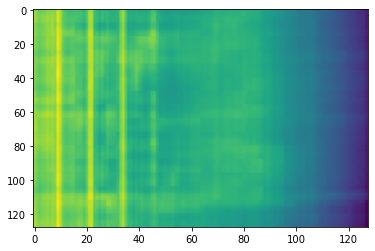

2020-11-11 19:58:59,376 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:16.560233, valid_AUC:0.569627, valid_pAUC:0.511901
100%|██████████| 1803/1803 [00:34<00:00, 51.52it/s]
2020-11-11 20:01:20,849 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:14.980484, valid_AUC:0.567708, valid_pAUC:0.513542
100%|██████████| 1803/1803 [00:36<00:00, 49.64it/s]
2020-11-11 20:03:44,843 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.645637, valid_AUC:0.609050, valid_pAUC:0.514565
100%|██████████| 1803/1803 [00:35<00:00, 51.44it/s]
2020-11-11 20:06:06,247 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.796809, valid_AUC:0.590780, valid_pAUC:0.513102
100%|██████████| 1803/1803 [00:34<00:00, 51.67it/s]
2020-11-11 20:08:26,448 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.842624, valid_AUC:0.631728, valid_pAUC:0.512145
100%|██████████| 1803/1803 [00:35<00:00, 50.66it/s]
2020-11-11 20:10:48,244 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.134828, valid_

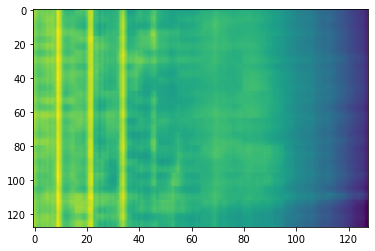

2020-11-11 20:21:29,163 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:9.449414, valid_AUC:0.622744, valid_pAUC:0.522161
100%|██████████| 1803/1803 [00:20<00:00, 87.03it/s]
2020-11-11 20:22:47,616 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:9.328728, valid_AUC:0.652096, valid_pAUC:0.522096
100%|██████████| 1803/1803 [00:21<00:00, 84.60it/s]
2020-11-11 20:24:06,056 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:9.196867, valid_AUC:0.641516, valid_pAUC:0.517894
100%|██████████| 1803/1803 [00:21<00:00, 85.15it/s]
2020-11-11 20:25:24,316 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:9.120091, valid_AUC:0.660257, valid_pAUC:0.525711
100%|██████████| 1803/1803 [00:20<00:00, 86.99it/s]
2020-11-11 20:26:41,243 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.057318, valid_AUC:0.642375, valid_pAUC:0.522142
100%|██████████| 1803/1803 [00:20<00:00, 88.37it/s]
2020-11-11 20:27:58,583 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:9.043024, valid_AUC:0.

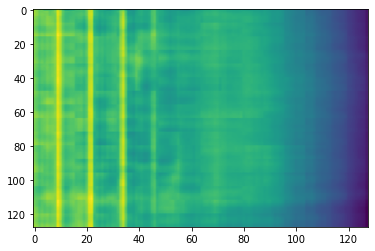

2020-11-11 20:34:15,491 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.139410, valid_AUC:0.628704, valid_pAUC:0.525716
  0%|          | 9/1803 [00:00<00:19, 90.00it/s]

Epoch    61: reducing learning rate of group 0 to 5.0000e-03.


100%|██████████| 1803/1803 [00:19<00:00, 93.18it/s]
2020-11-11 20:35:29,533 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.908966, valid_AUC:0.631761, valid_pAUC:0.524684
100%|██████████| 1803/1803 [00:19<00:00, 94.05it/s]
2020-11-11 20:36:43,392 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.735221, valid_AUC:0.651231, valid_pAUC:0.524102
100%|██████████| 1803/1803 [00:18<00:00, 95.05it/s]
2020-11-11 20:37:56,829 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.702191, valid_AUC:0.646109, valid_pAUC:0.525312
100%|██████████| 1803/1803 [00:19<00:00, 94.28it/s]
2020-11-11 20:39:10,339 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:8.694479, valid_AUC:0.647186, valid_pAUC:0.523033
100%|██████████| 1803/1803 [00:19<00:00, 94.15it/s]
2020-11-11 20:40:23,967 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:8.622093, valid_AUC:0.651873, valid_pAUC:0.523877
100%|██████████| 1803/1803 [00:18<00:00, 94.94it/s]
2020-11-11 20:41:37,391 - pytorch_modeler.py - I

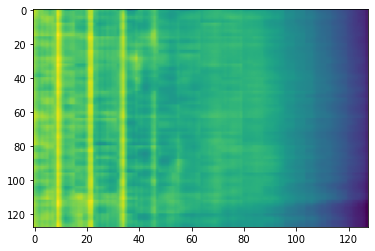

2020-11-11 20:46:31,746 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:8.444249, valid_AUC:0.649449, valid_pAUC:0.523549
100%|██████████| 1803/1803 [00:20<00:00, 86.10it/s]
2020-11-11 20:47:49,326 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:8.401902, valid_AUC:0.652723, valid_pAUC:0.523784
100%|██████████| 1803/1803 [00:19<00:00, 94.38it/s]
2020-11-11 20:49:04,718 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:8.371037, valid_AUC:0.647416, valid_pAUC:0.525884
100%|██████████| 1803/1803 [00:20<00:00, 88.97it/s]
2020-11-11 20:50:21,454 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:8.332632, valid_AUC:0.648496, valid_pAUC:0.525247
100%|██████████| 1803/1803 [00:20<00:00, 86.38it/s]
2020-11-11 20:51:38,448 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:8.281513, valid_AUC:0.642923, valid_pAUC:0.522865
100%|██████████| 1803/1803 [00:20<00:00, 89.56it/s]
2020-11-11 20:52:54,867 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:8.259215, valid_AUC:0.

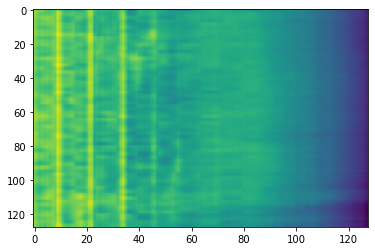

2020-11-11 20:59:18,993 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:8.132173, valid_AUC:0.661693, valid_pAUC:0.527929
100%|██████████| 1803/1803 [00:20<00:00, 89.69it/s]
2020-11-11 21:00:35,065 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:8.097404, valid_AUC:0.656828, valid_pAUC:0.526569
100%|██████████| 1803/1803 [00:22<00:00, 79.47it/s]
2020-11-11 21:01:54,211 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:8.103249, valid_AUC:0.653002, valid_pAUC:0.527291
100%|██████████| 1803/1803 [00:26<00:00, 68.57it/s]
2020-11-11 21:03:17,227 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:8.058393, valid_AUC:0.653845, valid_pAUC:0.524834
100%|██████████| 1803/1803 [00:23<00:00, 77.90it/s]
2020-11-11 21:04:37,411 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:8.048022, valid_AUC:0.657379, valid_pAUC:0.525097
100%|██████████| 1803/1803 [00:22<00:00, 78.63it/s]
2020-11-11 21:05:58,044 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:7.999760, valid_AUC:0.

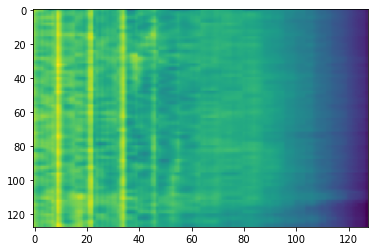

2020-11-11 21:12:38,767 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:7.855477, valid_AUC:0.653851, valid_pAUC:0.526325
100%|██████████| 1803/1803 [00:22<00:00, 78.52it/s]
2020-11-11 21:13:58,681 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:7.866713, valid_AUC:0.657459, valid_pAUC:0.528388
  0%|          | 8/1803 [00:00<00:23, 75.60it/s]

Epoch    92: reducing learning rate of group 0 to 2.5000e-03.


100%|██████████| 1803/1803 [00:22<00:00, 78.62it/s]
2020-11-11 21:15:19,229 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:7.868704, valid_AUC:0.656614, valid_pAUC:0.527929
100%|██████████| 1803/1803 [00:22<00:00, 78.64it/s]
2020-11-11 21:16:37,878 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:7.752619, valid_AUC:0.665462, valid_pAUC:0.528820
100%|██████████| 1803/1803 [00:22<00:00, 78.44it/s]
2020-11-11 21:17:57,887 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:7.720908, valid_AUC:0.660650, valid_pAUC:0.526635
100%|██████████| 1803/1803 [00:22<00:00, 79.64it/s]
2020-11-11 21:19:16,839 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:7.718321, valid_AUC:0.664612, valid_pAUC:0.527488
100%|██████████| 1803/1803 [00:22<00:00, 79.27it/s]
2020-11-11 21:20:36,012 - pytorch_modeler.py - INFO - Epoch 96/100:train_loss:7.697706, valid_AUC:0.659335, valid_pAUC:0.528885
100%|██████████| 1803/1803 [00:22<00:00, 80.06it/s]
2020-11-11 21:21:54,619 - pytorch_modeler.py - I

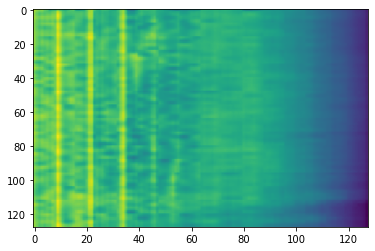

2020-11-11 21:25:52,944 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:7.639811, valid_AUC:0.661721, valid_pAUC:0.528810
2020-11-11 21:25:53,115 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM3CNN_AE_tune/models/fan_model.pth


elapsed time: 8583.904660225 [sec]


2020-11-11 21:25:53,772 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-11 21:25:53,773 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-11 21:25:53,774 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:13<00:00, 59.96it/s]


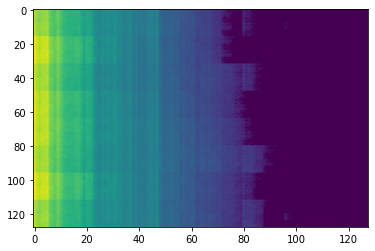

2020-11-11 21:27:55,750 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:937.316012, valid_AUC:0.301348, valid_pAUC:0.487360
100%|██████████| 832/832 [00:09<00:00, 90.58it/s]
2020-11-11 21:28:54,416 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:871.179364, valid_AUC:0.305041, valid_pAUC:0.487878
100%|██████████| 832/832 [00:09<00:00, 89.75it/s]
2020-11-11 21:29:53,391 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:814.519431, valid_AUC:0.309277, valid_pAUC:0.488091
100%|██████████| 832/832 [00:09<00:00, 91.02it/s]
2020-11-11 21:30:52,426 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:757.455341, valid_AUC:0.282847, valid_pAUC:0.487147
100%|██████████| 832/832 [00:09<00:00, 89.41it/s]
2020-11-11 21:31:51,764 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:706.981708, valid_AUC:0.321455, valid_pAUC:0.488852
 57%|█████▋    | 52/91 [00:29<00:22,  1.77it/s]


KeyboardInterrupt: 

In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)